##### Introduction

This notebook demonstrates how to use the WordCloud class from the Shekar library to generate Persian word clouds with proper font rendering, reshaping, and masking. It supports right-to-left scripts by integrating arabic_reshaper and python-bidi, ensuring that Persian words appear in their correct visual form.

You can customize the word cloud using different fonts, color maps, and mask shapes such as the map of Iran, a heart, a light bulb, or even your own image file.

To install Shekar, uncomment and run the following cell:

In [1]:
# !pip install shekar 

##### Data Prepration

In this example, we'll create a Persian word cloud from the short story "فارسی شکر است" by Mohammad Ali Jamalzadeh. We'll start by downloading the story from an online source and inspecting the raw HTML response to understand its structure before preprocessing the content.

In [2]:
import requests

url = f"https://shortstories.ir/entry/%d9%81%d8%a7%d8%b1%d8%b3%db%8c-%d8%b4%da%a9%d8%b1-%d8%a7%d8%b3%d8%aa-%d9%85%d8%ad%d9%85%d8%af%d8%b9%d9%84%db%8c-%d8%ac%d9%85%d8%a7%d9%84-%d8%b2%d8%a7%d8%af%d9%87"
response = requests.get(url)
html_content = response.text
print(html_content[0:1000])

<!doctype html>
<html dir="rtl" lang="fa-IR" class="no-js">
<head>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" />
<meta name="HandheldFriendly" content="true" /><title>فارسی شکر است — محمدعلی جمال‌زاده &#8211; داستان کوتاه</title>
<meta name='robots' content='max-image-preview:large' />
	<style>img:is([sizes="auto" i], [sizes^="auto," i]) { contain-intrinsic-size: 3000px 1500px }</style>
	<link rel='dns-prefetch' href='//rawcdn.githack.com' />
<link href='https://rawcdn.githack.com' crossorigin rel='preconnect' />
<link rel="alternate" type="application/rss+xml" title="داستان کوتاه &raquo; خوراک" href="https://shortstories.ir/feed" />
<link rel="alternate" type="application/rss+xml" title="داستان کوتاه &raquo; خوراک دیدگاه‌ها" href="https://shortstories.ir/comments/feed" />
<meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,user-scalable=no" />

After fetching the story, we are left with a wall of raw HTML filled with tags, extra symbols, and irrelevant characters. It's not something we can feed directly into a word cloud generator. We need to clean the text and bring it into shape.

To do this, we use Shekar's built-in text transformers. These are modular components designed to handle specific cleaning tasks. By chaining them together, we build a preprocessing pipeline that takes care of the messy content for us.

Here's what each component in the pipeline does:

- **HTMLTagRemover** strips out all HTML elements like &lt;div&gt;, &lt;span&gt;, and other tags that do not belong in the actual text.

- **DiacriticsRemover** removes short vowels and other diacritical marks that are often unnecessary in Persian text analysis.

- **PunctuationRemover** takes care of punctuation symbols such as commas, question marks, and periods.

- **StopWordRemover** eliminates common Persian stop words that appear frequently but add little meaning in word frequency analysis.

- **NonPersianRemover** removes any character that is not part of the Persian alphabet, such as Latin letters or digits.

Once the text is cleaned, we apply a couple of normalization steps:

- **ArabicUnicodeNormalizer** replaces Arabic characters that look similar but have different Unicode values with their standard Persian equivalents.

- **SpacingStandardizer** corrects spacing issues, ensuring that words are properly separated and no extra whitespace is present.

Together, these steps form a complete preprocessing pipeline:

In [3]:
from shekar.preprocessing import (
  HTMLTagRemover,
  DiacriticsRemover,
  PunctuationRemover,
  StopWordRemover,
  NonPersianRemover,
  ArabicUnicodeNormalizer,
  SpacingStandardizer,
)
cleaners = HTMLTagRemover() | DiacriticsRemover() | PunctuationRemover() | StopWordRemover() | NonPersianRemover()
normalizers = ArabicUnicodeNormalizer() | SpacingStandardizer()

preprocessing_pipeline = cleaners | normalizers

In [4]:
clean_text = preprocessing_pipeline(html_content)
print(clean_text[0:1000])

فارسی شکر محمدعلی جمال‌زاده داستان کوتاه فهرست پدیدآورندگان پیشنهاد تماس ۱۵ دقیقه نسخه چاپی منبع فارسی شکر محمدعلی جمال‌زاده دنیا خشک ایران نمی‌سوزانند سال دری خون جگری چشمم صفحه کشتی خاک پاک ایران نیفتاده آواز گیلکی کرجی‌بان‌های انزلی گوشم بالام جان بالام جان خوانان مورچه‌هایی ملخ مرده‌ای بگیرند کشتی بلای جان مسافرین ریش مسافری چنگ پاروزن کرجی بان حمال افتاد مسافرین کار زارتر سایرین عموما کاسب‌کارهای لباده دراز کلاه کوتاه باکو رشت زور چماق واحد یموت بند کیسه‌شان جان عزرائیل رنگ پولشان نمی‌بیند بخت برگشته مادر مرده مجال کلاه لگنی فرنگیم فرنگستان سرم مانده عوض یاروها پسر حاجی لقمه چربی فرض صاحب صاحب گویان دورمان تکه اسباب‌هایمان مایه‌النزاع ده راس حمال پانزده نفر کرجی‌بان بی‌انصاف جیغ فریادی بلند قشقره‌ای برپا گردید سرش مات متحیر انگشت دهن سرگردان مانده بودیم بامبولی یخه‌مان چنگ ایلغاریان خلاص حقه لمی گیرشان بجهیم صف شکافته عنق منکسر منحوس نفر ماموران تذکره انگاری انکر منکر نفر فراش سرخ پوش شیر خورشید کلاه صورت‌هایی اخمو عبوس سبیل‌های چخماقی بناگوش دررفته‌ای بیرق جوع گرسنگی نسیم دریا حر

Now that the raw HTML has taken a spin through our text-washing machine, it's fresh, clean, and neatly pressed. All set and ready to shine in a beautiful Persian word cloud!

#### Creating Persian Word Clouds

Now that we’ve cleaned and prepared our text, it’s time to bring the words to life with a beautiful Persian word cloud. The **WordCloud** class in Shekar provides a flexible and culturally aware way to visualize word frequencies, with built-in support for Persian fonts, character reshaping, and optional masks.

##### Parameters You Can Customize


| Parameter          | Description                                                                                                                              |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------- |
| `mask`             | Optional shape mask for the word cloud. Use `"Iran"`, `"Heart"`, `"Bulb"`, `"Cat"`, `"Cloud"`, `"Head"`, or provide a custom image path. If *None* it will generate a rectangle. |
| `font`             | Font to use. Choose `"sahel"` or `"parastoo"`, or provide a custom TTF font path.                                                        |
| `width`, `height`  | Size of the generated image in pixels. Ignored if mask provided.                                                                                                  |
| `bg_color`         | Background color (e.g., `"white"`, `"black"`).                                                                                           |
| `contour_color`    | Outline color of the mask shape.                                                                                                         |
| `contour_width`    | Thickness of the outline.                                                                                                                |
| `color_map`        | Matplotlib color map for the words (e.g., `"viridis"`, `"plasma"`, `"Greens"`).                                                          |
| `min_font_size`    | Minimum font size in the word cloud.                                                                                                     |
| `max_font_size`    | Maximum font size in the word cloud.                                                                                                     |
| `horizontal_ratio` | Controls how many words appear horizontally. A value between `0.0` and `1.0` (default is `0.75`).                                        |


##### Generating a Word Cloud for "فارسی شکر است"
We’ll tokenize the cleaned text, count word frequencies, and pass them to the WordCloud generator:

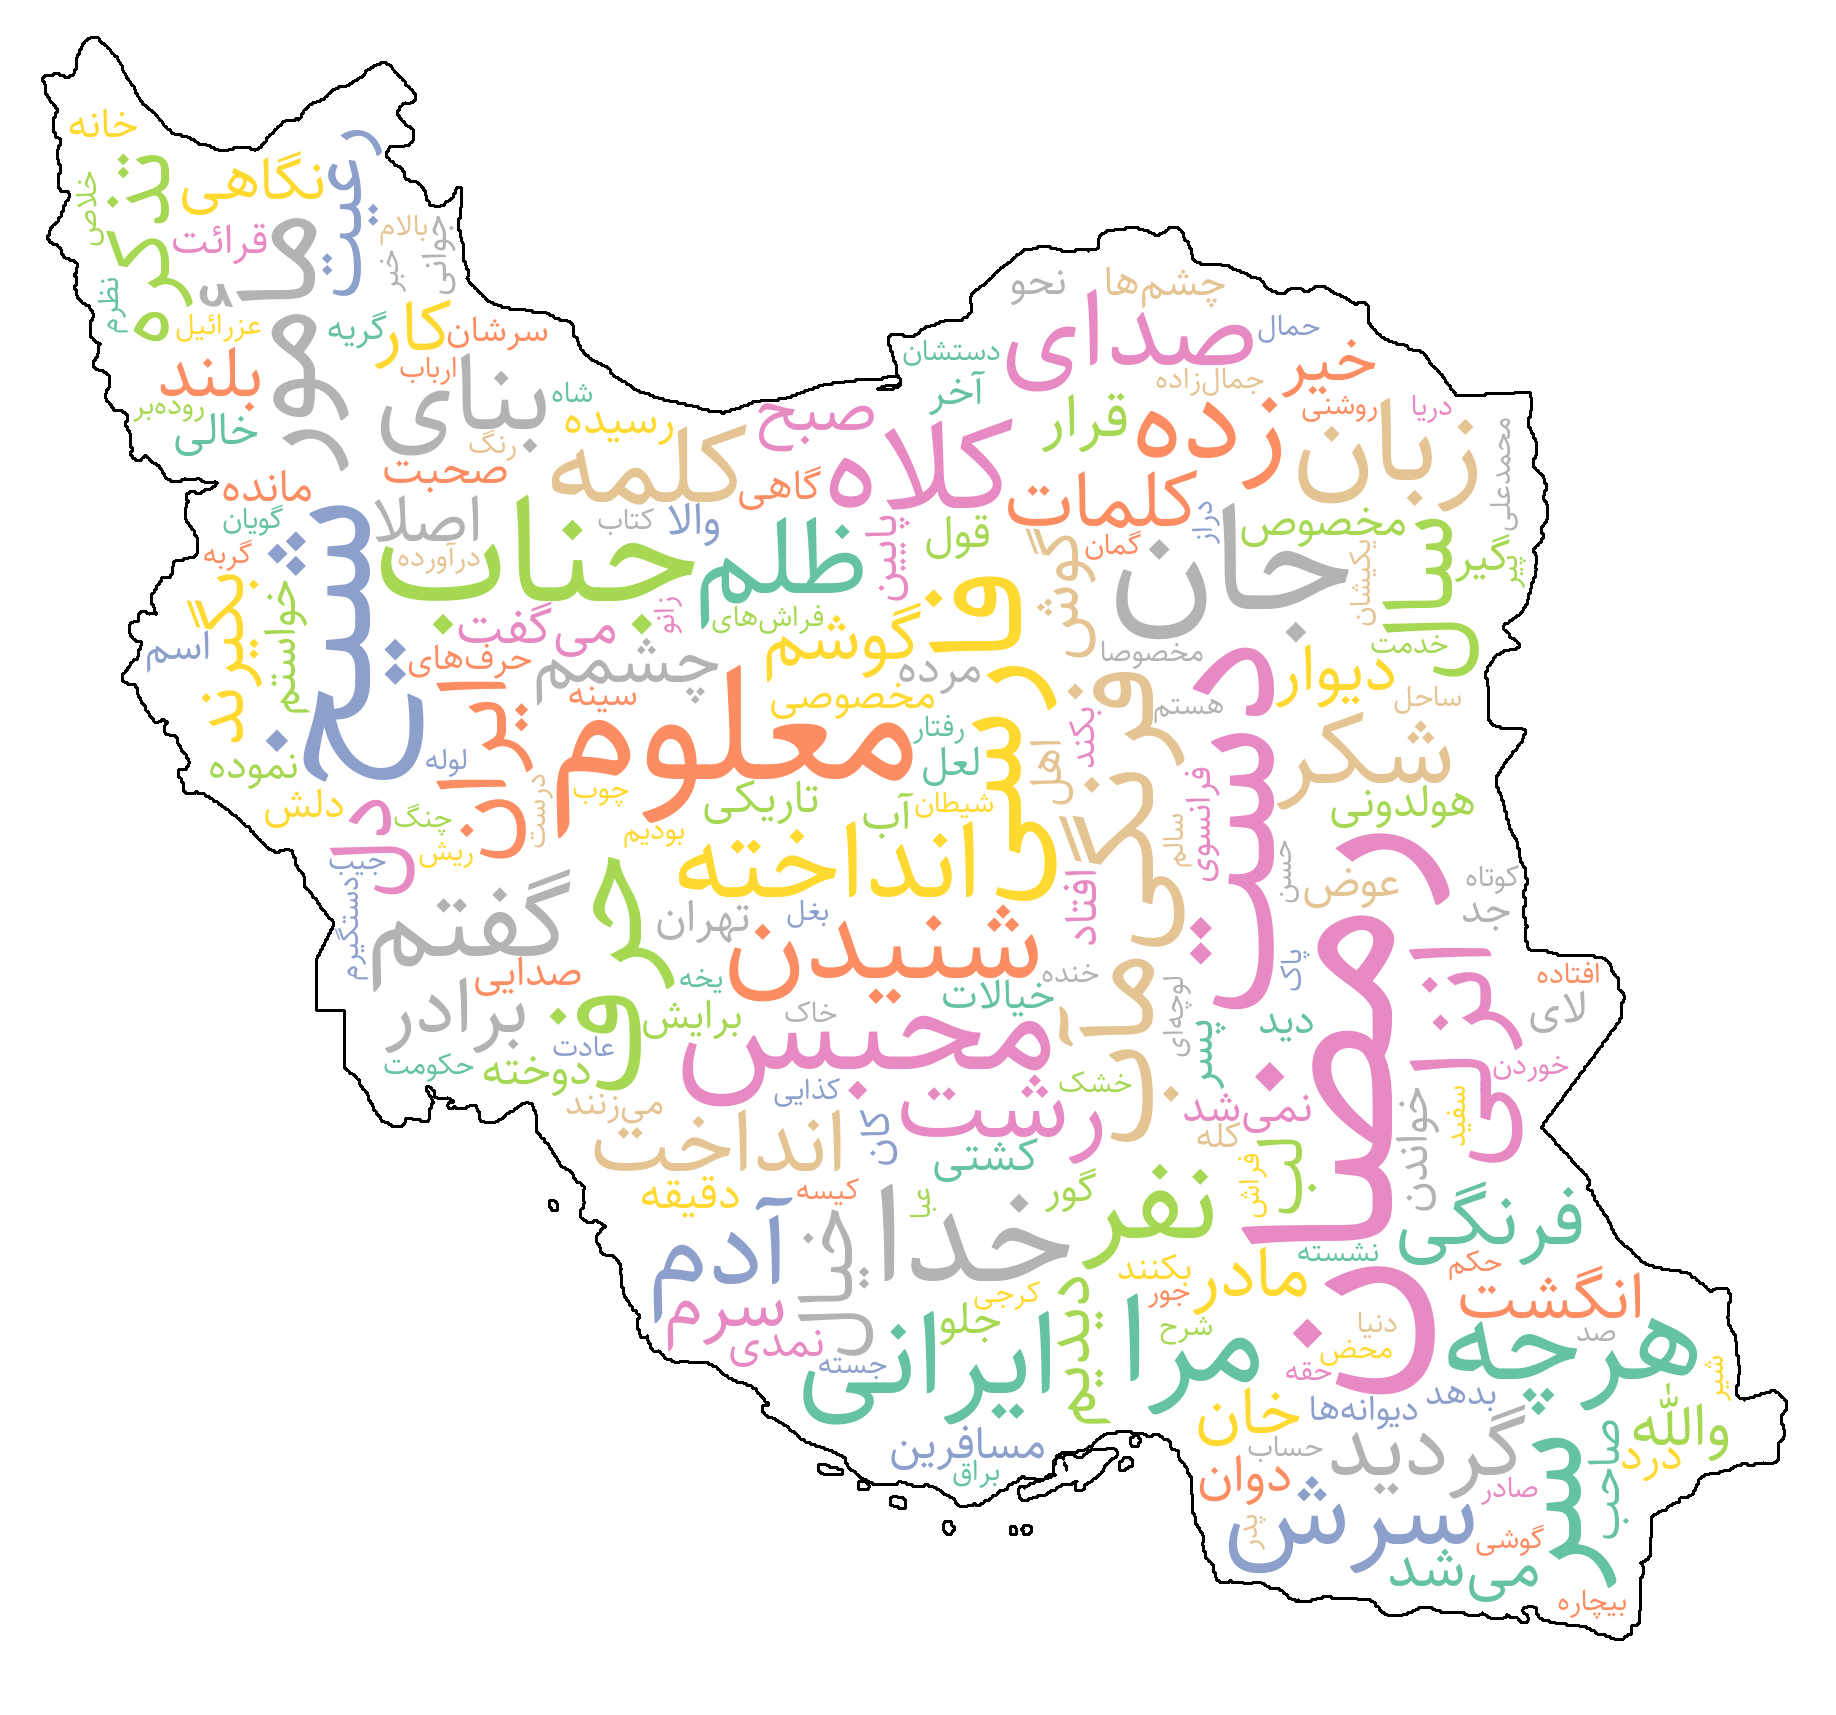

In [5]:
from shekar import WordCloud
from collections import Counter
from shekar import utils
from shekar import WordTokenizer


word_tokenizer = WordTokenizer()
tokens = word_tokenizer(clean_text)

counwords = Counter()
for word in tokens:
    if word not in utils.stopwords:
        counwords[word] += 1


worCloud = WordCloud(
        mask="Iran",
        width=1000,
        height=500,
        max_font_size=220,
        min_font_size=5,
        bg_color="white",
        contour_color="black",
        contour_width=3,
        color_map="Set2",
    )

image = worCloud.generate(counwords)
image

Pretty cool, huh? Now that you’ve seen it in action, feel free to play around with the settings and explore different configurations. Change the mask shape, switch up the color map, or try a new font to see how each adjustment transforms the final word cloud. It’s a fun way to experiment and discover the visual style that works best for your text.

##### Using a Custom Mask

Want to make your word cloud even more personalized? You can provide your own custom shape by passing the path to a binary mask image file. This allows you to generate word clouds that fit any silhouette you like, whether it's a logo, symbol, or artistic design!

##### How It Works
A mask is simply a black-and-white image where:
- The black (0) areas define the regions where words can appear.
- The white (255) areas will be left blank.
This binary image acts like a stencil for your word cloud.

##### Example
Let’s say you have a custom shape saved as cat.png, which is a black-and-white silhouette of a cat. We’ll start by loading and visualizing the mask image, then use it to generate a word cloud.

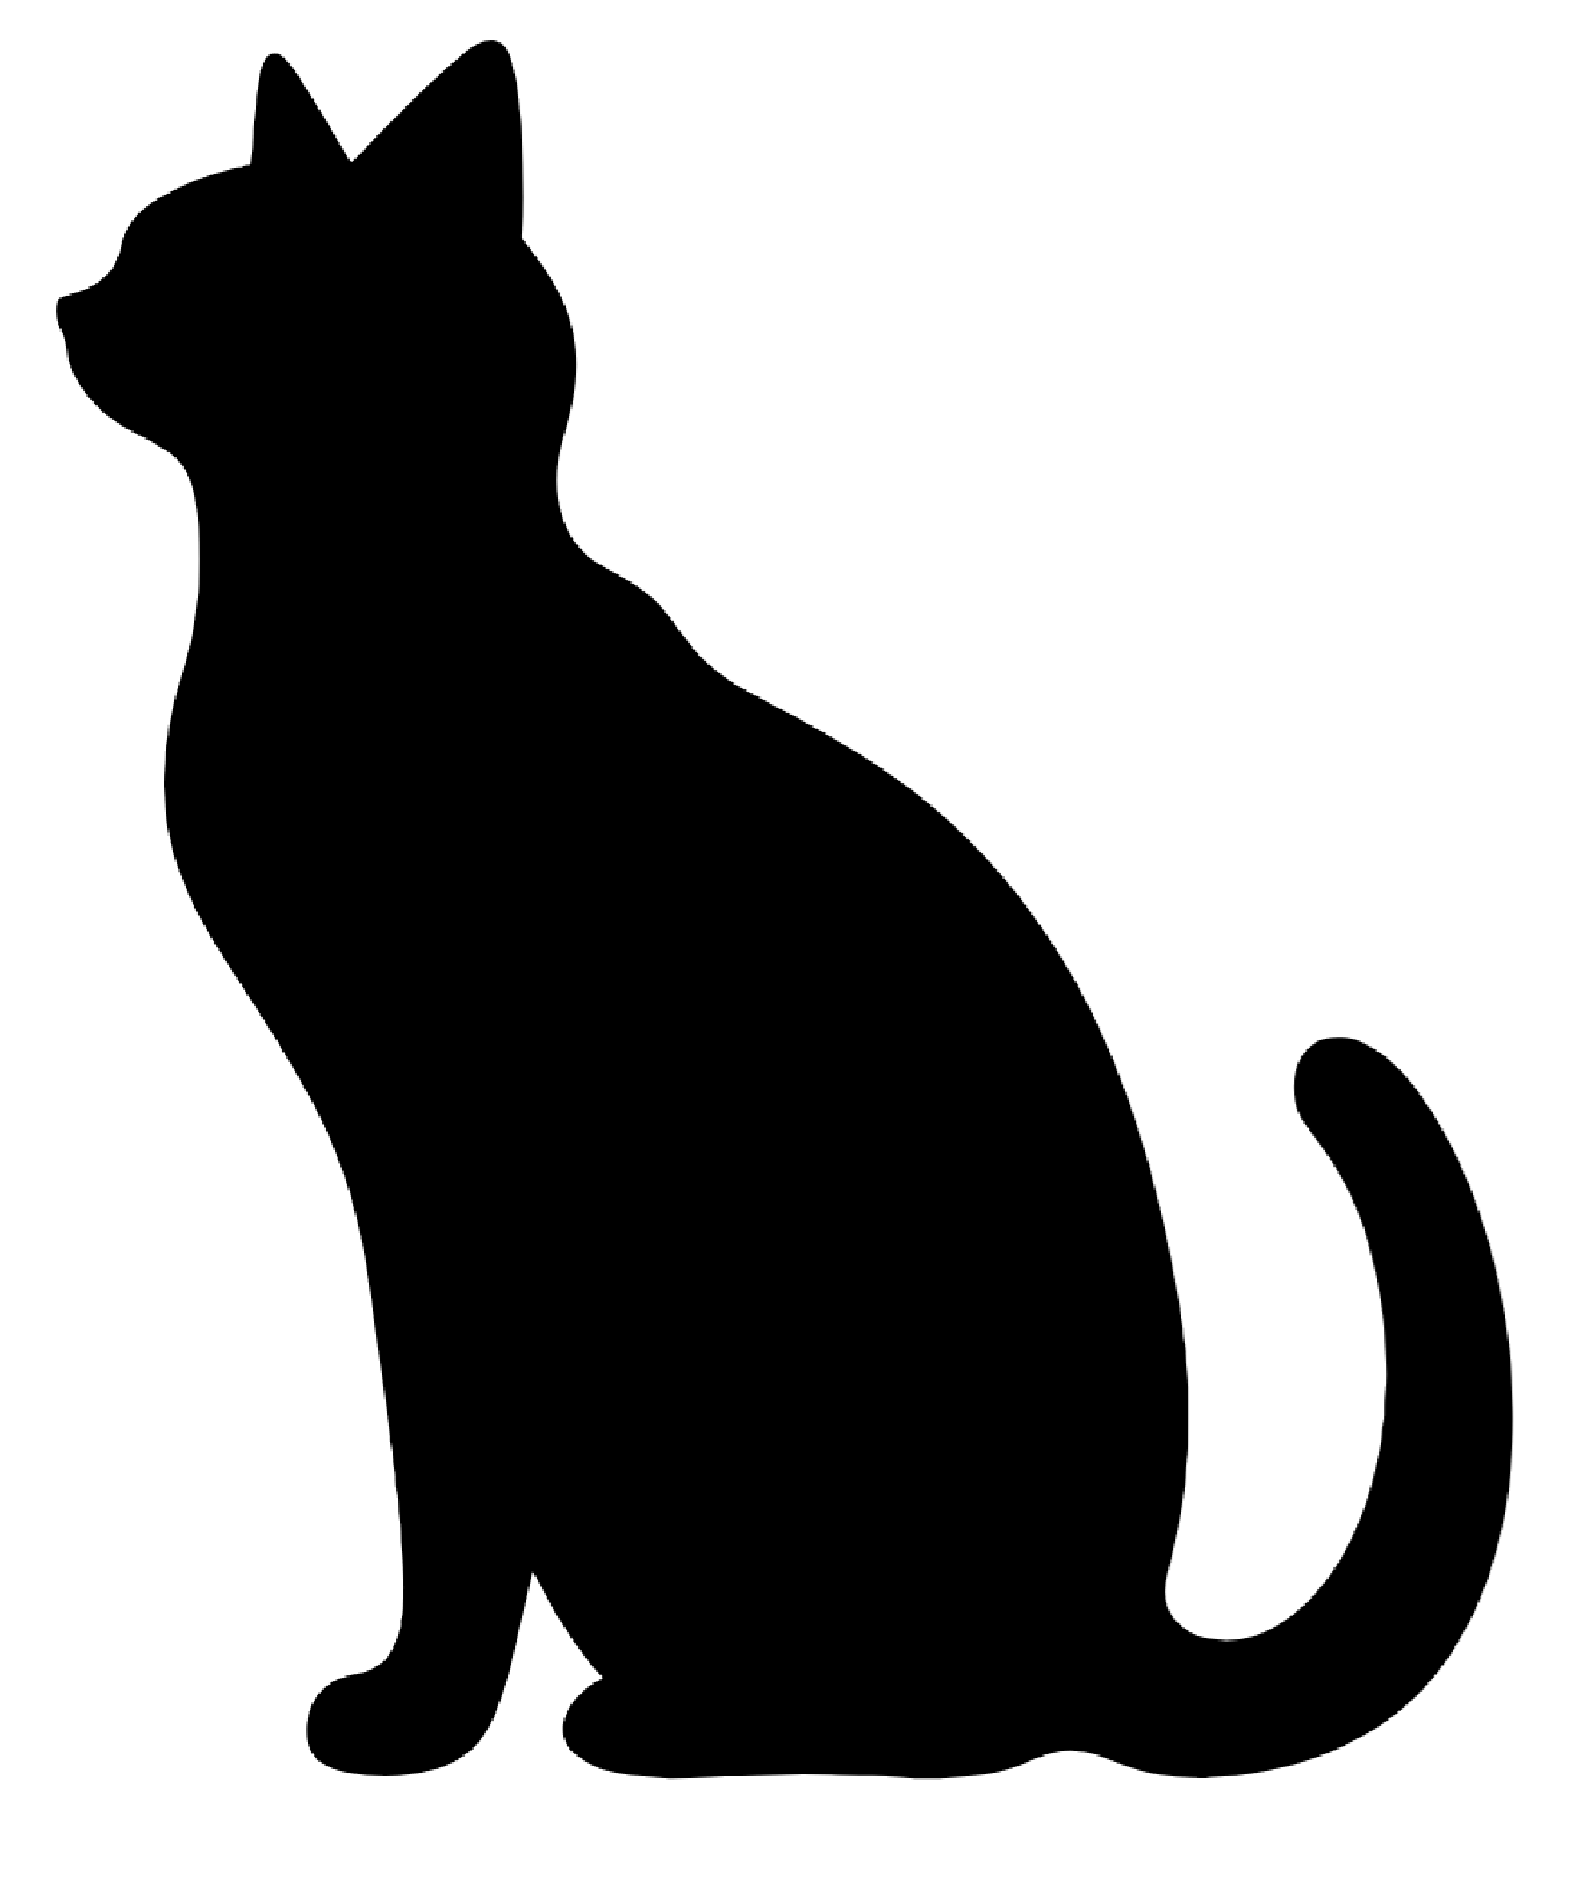

In [6]:
from shekar import utils
from PIL import Image
mask_path  = utils.data_root_path / "masks" / "cat.png"
mask_image = Image.open(mask_path)
mask_image

The black areas in the mask are where the words will be placed. White or transparent areas will remain empty in the final image.

**Generate Word Cloud with the Custom Mask**

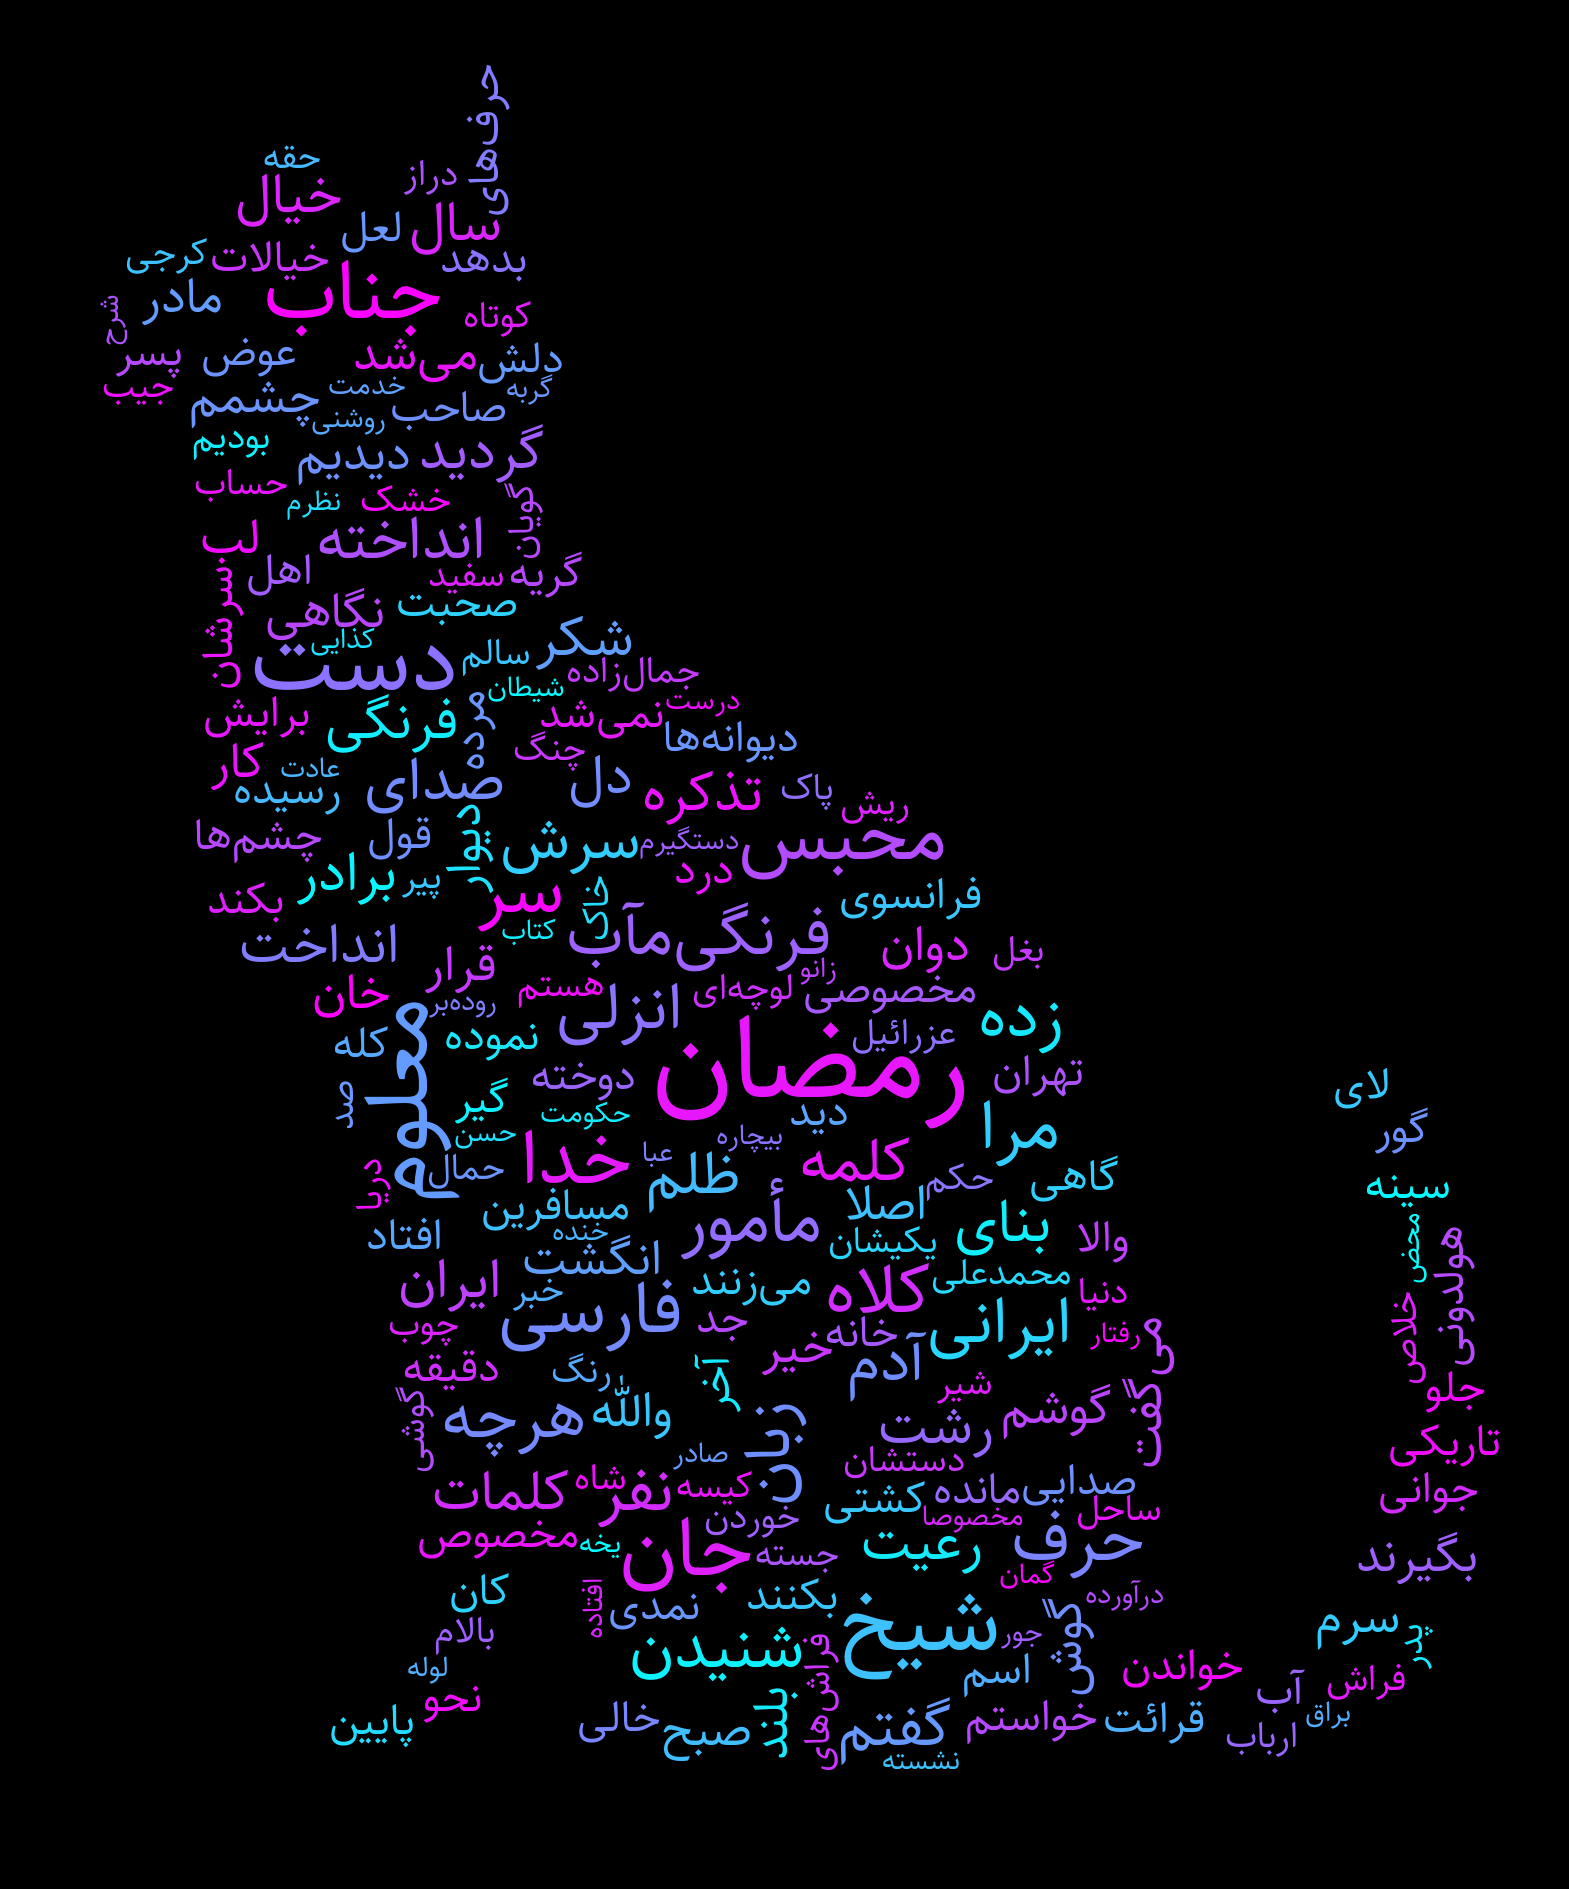

In [7]:
my_wordcloud = WordCloud(
    mask=str(mask_path),
    font="sahel",
    color_map="cool",
    bg_color="black",
    contour_color="black",
    contour_width=4,
    min_font_size=8,
    max_font_size=120,
    horizontal_ratio=0.90
)

image = my_wordcloud.generate(counwords)
image


**Tips for Creating Your Own Mask**

- Use a black-and-white PNG with a white background.
- Make sure the black area forms a clear, continuous shape.
- Avoid overly detailed or thin designs for better word visibility.

With a custom mask, your word clouds can reflect your project’s theme, brand, or creative vision.